# Introduction

This notebook will compare results from a reimplemnation of the Reno-Hanson clear sky detection method to that which is available in PVLib.  Their method is being reimplemented here so it will be easier to extract the calculated properties for further analysis and processing.  

# Setup

## Imports, config, etc

In [1]:
import numpy as np
import pandas as pd
import datetime
import pvlib
import model_comparison

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

import warnings
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

## Load data

Weather and performance data are taken at 1min intervals.  Supplier is the Sandia National Lab Regional Test Center in Albuquerque, NM.  Data spans roughly 2016-April 2017.  This data was scraped from PVDAQ (http://bit.ly/2mKrOwG).  The meteorological data and the performance data are contained in two separate files (technically separate systems - PV system and meteorological station).

SRRL data is available at https://www.nrel.gov/midc/srrl_bms/.  This data is being used because it was already downloaded for a different notebook.  Irradiance data is also measured on a minute-to-minute basis.

In [2]:
def load_snl():
    filename = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')
    cols = ['Global_Wm2', 'Date-Time']
    data = pd.read_csv(filename, parse_dates=['Date-Time'], usecols=cols, index_col=['Date-Time'])
    data.index = data.index.tz_localize('Etc/GMT+7')
    data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq='1min')).fillna(0)
    data = pd.Series(data['Global_Wm2'], index=data.index)
    data[data < 50] = 0 
    return data

In [3]:
def load_srrl():
    srrl_file = os.path.expanduser('~/data_sets/srrl/20140101.csv')
    srrl_data = pd.read_csv(srrl_file)
    srrl_data.index = pd.to_datetime(srrl_data['DATE (MM/DD/YYYY)'] + ' ' + srrl_data['MST'])
    srrl_data.index = srrl_data.index.tz_localize('Etc/GMT+7')
    srrl_data = srrl_data[~srrl_data.index.duplicated(keep='first')]
    srrl_data.drop(['DATE (MM/DD/YYYY)', 'MST'], inplace=True, axis=1)
    srrl_data = pd.Series(srrl_data['Global 40-South LI-200 [W/m^2]'], index=srrl_data.index)
    srrl_data[srrl_data < 50] = 0
    srrl_data2 = pd.Series(0, index=pd.date_range(start=srrl_data.index.date[0], 
                                                  end=srrl_data.index.date[-1] + pd.Timedelta('1D'), freq='1min'))
    srrl_data2.index = srrl_data2.index.tz_localize('Etc/GMT+7')
    srrl_data2[srrl_data.index] = srrl_data
    srrl_data = srrl_data2.copy()
    return srrl_data

In [4]:
snl_data = load_snl()
srrl_data = load_srrl()

## PVLib

In [5]:
def make_pvlib_sys(tilt, elevation, azimuth, lat, lon):
    sys_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=tilt, surface_azimuth=azimuth)
    sys_loc = pvlib.location.Location(lat, lon, altitude=elevation)
    sys = pvlib.pvsystem.LocalizedPVSystem(pvsystem=sys_no_loc, location=sys_loc)
    return sys

In [6]:
snl_params = {'tilt': 35, 'elevation': 1658, 'azimuth': 180, 
              'lat': 35.0549, 'lon': -106.5433}
rtc = make_pvlib_sys(**snl_params)

In [7]:
srrl_params = {'tilt': 40, 'elevation': 1828.8, 'azimuth': 180, 
               'lat': 39.742, 'lon': -105.18}
srrl = make_pvlib_sys(**srrl_params)

## Analysis functions

In [16]:
def scatter_components(data, clear, x, y):
    fig, ax = plt.subplots()
    ax.scatter(data[x][~clear], data[y][~clear], 
               edgecolor='red', facecolor='none', alpha=.1)
    ax.scatter(data[x][clear], data[y][clear], 
               edgecolor='green', facecolor='none', alpha=.1)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

In [25]:
def scatter3d_components(data, clear, x, y, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[x][~clear], data[y][~clear], data[z][~clear],
               edgecolor='red', facecolor='none', alpha=.1)
    ax.scatter(data[x][clear], data[y][clear], data[z][clear],
               edgecolor='green', facecolor='none', alpha=.1)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

In [78]:
import itertools
def custom_pairplot(data, clear, cols):
    fig, axes = plt.subplots(nrows=len(cols), ncols=len(cols), figsize=(2 * len(cols), 1.5 * len(cols)))
    for i, j in itertools.combinations_with_replacement(range(len(cols)), 2):
        if i == j:
            axes[i, j].hist(data[cols[i]].dropna())
        else:
            axes[i, j].scatter(data[~clear][cols[i]], data[~clear][cols[j]],
                               edgecolor='red', facecolor='none', s=15, alpha=.1)
            axes[i, j].scatter(data[clear][cols[i]], data[clear][cols[j]],
                   edgecolor='green', facecolor='none', s=15, alpha=.1)
        
        # if i == len(cols) - 1:
        #     axes[i, j].set_xlabel(cols[i])
        # if j == 0 and i > 0:
        #     axes[i, j].set_ylabel(cols[j])
    fig.tight_layout()

# Investigation

## Sandia RTC

In [10]:
sample = snl_data[(snl_data.index >= '2016-07-01') & (snl_data.index < '2016-07-15')]

### Generate model clear sky irradiance and detect clear skies in sample using PVLib functionality.

In [11]:
clear_skies = rtc.get_clearsky(sample.index)
clear_skies = pd.Series(clear_skies['ghi'], index=sample.index)
pvlib_clear, components, alpha = \
    pvlib.clearsky.detect_clearsky(sample, clear_skies, 
                                   sample.index, 10, return_components=True)

### Detect clear skies using reimplementation of RH method

In [12]:
mc = model_comparison.ModelCompareDetect(sample, clear_skies)

In [13]:
compare_clear, components = mc.reno_hansen_detection(verbose=True)

In [14]:
components['component_vals'].keys()

Index(['meas_avg', 'model_avg', 'meas_max', 'model_max', 'meas_line_length',
       'model_line_length', 'meas_slope_std', 'model_slope_std',
       'max_slope_dev'],
      dtype='object')

In [15]:
data = components['component_vals'][['meas_avg', 'meas_max', 'meas_line_length', 'meas_slope_std', 'max_slope_dev']]

In [27]:
data['time'] = data.index
data['min_from_noon'] = data['time'].apply(lambda x: np.abs(1440 - (((60 * x.hour) + x.minute))))
data.drop('time', axis=1, inplace=True)
                                                                   

In [19]:
data['meas_line_length_norm'] = mc.calc_property(mc.data, mc.calc_window_line_length_norm)

In [20]:
data['window_integral'] = mc.calc_property(mc.data, mc.calc_window_integral)

In [21]:
data['avg_derivative'] = mc.calc_property(mc.data, mc.calc_window_derivative_avg)

<IPython.core.display.Javascript object>


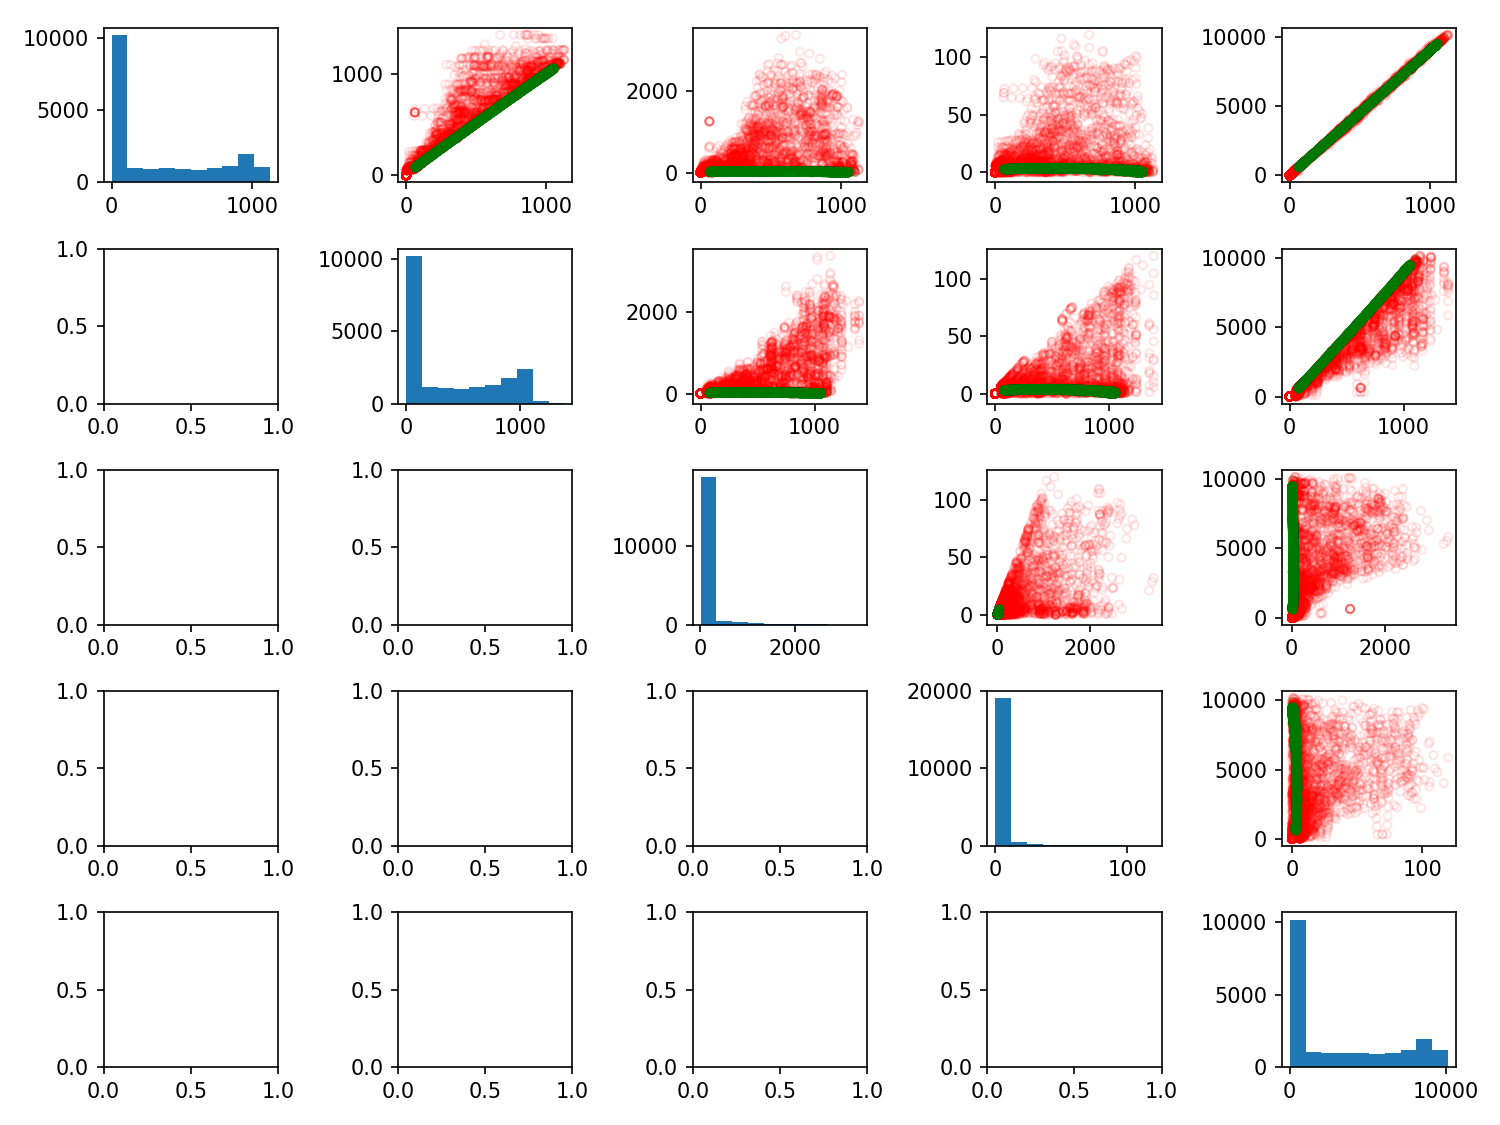

In [80]:
custom_pairplot(data, compare_clear, ['meas_avg', 'meas_max', 'meas_line_length', 'abs_avg_derivative', 'window_integral'])